# Netflix Recommendation Data Manipulation & Collaborative Filtering

In [1]:
#I've installed surprise from the terminal already
#Importing necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from scipy.sparse import csr_matrix #this one I've never used before
from surprise import Reader, Dataset, SVD,KNNBaseline, SVDpp, SlopeOne, NMF
from surprise.model_selection import cross_validate, KFold, ShuffleSplit, GridSearchCV

In [2]:
#Setting path to the data

path = os.getcwd()
os.chdir(path + "/RawData")
os.getcwd()

'/Users/josephberkowitz/NetflixRecommender/RawData'

In [3]:
#reading first training data into pandas dataframe

df1 = pd.read_csv("combined_data_1.txt", header = None, names = ["cust_Id", "Rating"], usecols = [0, 1])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
cust_Id    object
Rating     float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [5]:
#Looking at dataset shape
print('Dataset 1 shape: {}'.format(df1.shape))

Dataset 1 shape: (24058263, 2)


In [ ]:
#Reading in the other datasets
df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)


print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

In [7]:
#Combining Datasets
df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [9]:
#Checking the spread of the ratings
p = df.groupby('Rating')['Rating'].agg(['count'])
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [11]:
# get movie count
movie_count = df.isnull().sum()[1]
movie_count

4499

In [13]:
# get rating count
rating_count = df['cust_Id'].count() - movie_count
rating_count

24053764

In [16]:
# get customer count
cust_count = df['cust_Id'].nunique() - movie_count
cust_count

470758

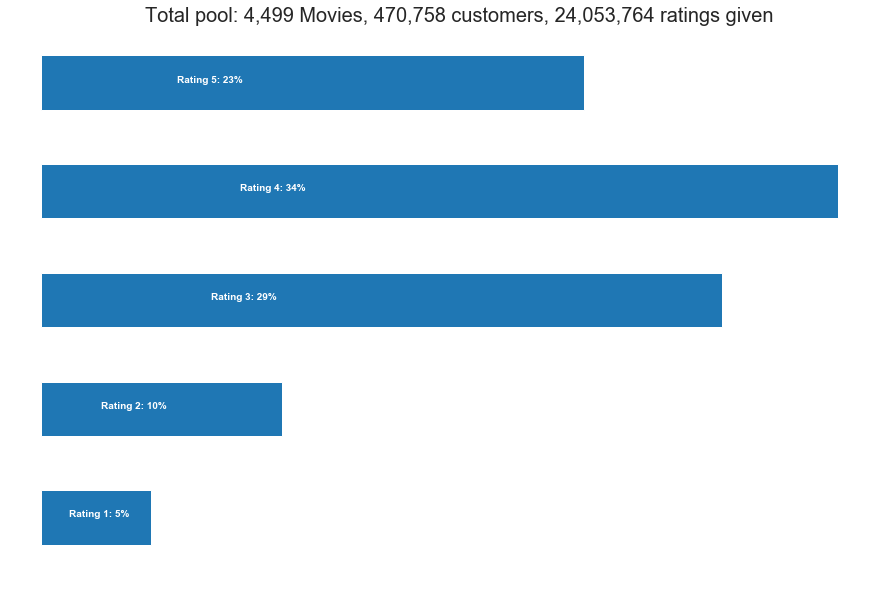

In [17]:
#Plotting Ratings
sns.set_style("darkgrid")
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [19]:
#pulling MovieID out of the dataframe and then adding it as a column to the full DF
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

In [20]:
movie_np = []
movie_id = 1

In [24]:
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [25]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

In [26]:
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [27]:
# remove those Movie ID rows from the full DF
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['cust_Id'] = df['cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/Users/josephberkowitz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


-Dataset examples-
          cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/Users/josephberkowitz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
#Removing movies with not enough ratings and removing customers who haven't rated enough
f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
df_movie_summary.head()

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298


In [30]:
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
movie_benchmark
#Movie has to be rated at least 1799 times to be counted?

1799.0

In [32]:
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
drop_movie_list

Int64Index([   1,    2,    4,    5,    6,    7,    9,   10,   11,   12,
            ...
            4484, 4486, 4487, 4489, 4491, 4494, 4495, 4497, 4498, 4499],
           dtype='int64', name='Movie_Id', length=3149)

In [33]:
print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [35]:
df_cust_summary = df.groupby('cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 52.0


In [37]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (22629885, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [38]:
df_p = pd.pivot_table(df,values='Rating',index='cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [40]:
#Loading in the movie titles file
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [43]:
#Running collaborative filtering model

reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

In [45]:
#Running SVD with 5 fold cross validation on the first 100k rows of the dataset
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9930  0.9970  0.9988  0.9907  1.0050  0.9969  0.0050  
MAE (testset)     0.7975  0.8022  0.8029  0.7972  0.7968  0.7993  0.0026  
Fit time          6.39    6.84    12.74   7.77    8.16    8.38    2.27    
Test time         0.29    0.19    0.30    0.16    0.19    0.22    0.06    


{'test_rmse': array([0.99300273, 0.99696253, 0.99880015, 0.9906961 , 1.00500706]),
 'test_mae': array([0.79753435, 0.8021899 , 0.8028593 , 0.79721341, 0.79677513]),
 'fit_time': (6.393896818161011,
  6.840944051742554,
  12.73501706123352,
  7.770370960235596,
  8.15575385093689),
 'test_time': (0.2850630283355713,
  0.19254803657531738,
  0.30106592178344727,
  0.15520286560058594,
  0.1883249282836914)}

In [47]:
df_785314 = df[(df['cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

In [50]:
#Predicting what this user would watch
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
algo.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: algo.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                       Name  Estimate_Score
721   2003.0         The Wire: Season 1        5.000000
1551  1983.0                Black Adder        5.000000
67    2004.0                Invader Zim        4.867014
3167  1987.0  Evil Dead 2: Dead by Dawn        4.812267
2217  1999.0   Black Adder Back & Forth        4.805738
4391  1993.0           Army of Darkness        4.788563
2113  2002.0                    Firefly        4.729826
2860  1996.0        Babylon 5: Season 4        4.723048
3667  2000.0         Farscape: Season 2        4.698458
2101  1994.0     The Simpsons: Season 6        4.685784
